In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

from cv23_lab1_part2_utils import interest_points_visualization
from cv23_lab1_part2_utils import disk_strel

In [2]:
up = cv2.imread('up.png', cv2.IMREAD_GRAYSCALE)

cells = cv2.imread('cells.jpg', cv2.IMREAD_GRAYSCALE)

kyoto = cv2.imread('kyoto_edges.jpg', cv2.IMREAD_GRAYSCALE)

In [3]:
sigma = 2
r = 2.5
k = 0.1
theta_corn = 0.05
s = 1.5
N = 4

In [4]:
def Gaussian (I, sigma):

        n= int(np.ceil(3*sigma)*2+1)

        gauss1D = cv2.getGaussianKernel(n, sigma)  # Column vector
        gauss2D = gauss1D @ gauss1D.T  # Symmetric gaussian kernel    

        Is = cv2.filter2D(I, -1, gauss2D)
        
        return(Is)

In [5]:
def Gauss2Dfilter(sigma):
    n= int(np.ceil(3*sigma)*2+1)

    gauss1D = cv2.getGaussianKernel(n, sigma)
    gauss2D = gauss1D @ gauss1D.T
    return gauss2D

In [6]:
def CornerDetect (I, sigma, r, k, theta_corn):

    def Gaussian (I, sigma):

        n= int(np.ceil(3*sigma)*2+1)

        gauss1D = cv2.getGaussianKernel(n, sigma)  # Column vector
        gauss2D = gauss1D @ gauss1D.T  # Symmetric gaussian kernel    

        Is = cv2.filter2D(I, -1, gauss2D)
        
        return(Is)

    I= np.float32(I)

    Is = Gaussian(I, sigma)

    Ix, Iy = np.gradient(Is)

    Ix2 = np.square(Ix)
    Ixy = Ix * Iy
    Iy2 = np.square(Iy)

    j1= Gaussian(Ix2, r)
    j2= Gaussian(Ixy, r)
    j3= Gaussian(Iy2, r)


    lambda_plus = 1 / 2 * (j1 + j3 + np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))
    lambda_minus = 1 / 2 * (j1 + j3 - np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))

    R = lambda_plus * lambda_minus - k * (lambda_plus + lambda_minus) ** 2

    ns = np.ceil(3 * sigma) * 2 + 1
    B_sq = disk_strel(ns)
    Cond1 =( R == cv2.dilate(R, B_sq))

    maxR = np.max(R)
    Cond2 = (R > theta_corn * maxR)

   
    corners = np.zeros_like(I)

    
    corners[Cond1 & Cond2] = 1
    final_points = []
    x_indices, y_indices = np.nonzero(corners)
    final_points = np.column_stack((y_indices,x_indices, np.full_like(y_indices, sigma)))

    return(final_points)

(59, 3)


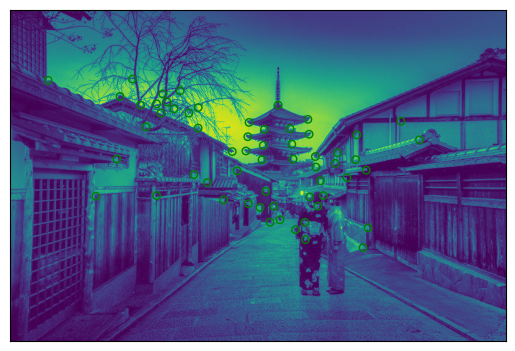

In [7]:
a= CornerDetect(kyoto, sigma, r, k, theta_corn)

interest_points_visualization(kyoto, a)

print(a.shape)

2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών

In [8]:
def MultiScaleCornerDetect(I, sigma, r, k, theta_corn, s, N):
    def Gauss2Dfilter(sigma):
        n= int(np.ceil(3*sigma)*2+1)

        gauss1D = cv2.getGaussianKernel(n, sigma)
        gauss2D = gauss1D @ gauss1D.T
        return gauss2D
    sigma_arr = []
    rho_arr = []
    corners = []
    LoG = []
    final_corners = []
    
    I = I.astype(float)/255

    for i in range(N):
        sigma_arr.append((s ** i) * sigma)
        rho_arr.append((s ** i) * r)

        corners.append(CornerDetect(I, sigma_arr[i], rho_arr[i], k, theta_corn))
        
        kernel = Gauss2Dfilter(sigma_arr[i])
        kernel = sigma_arr[i]**2 * cv2.Laplacian(kernel, cv2.CV_64F)
        LoG.append(np.abs(cv2.filter2D(I, -1, kernel)))
        
    

    
    for i in range(N):
        for j in range(len(corners[i])):
            # corners[i] contains all the edge points for σi
            y, x, sigmai = corners[i][j]
            currentLog = LoG[i][x, y]                
            if i == 0:
                previousLog = 0
                nextLog = LoG[i+1][x, y]
            elif i == N-1:
                previousLog = LoG[i-1][x, y]
                nextLog = 0
            else: 
                previousLog = LoG[i-1][x, y]
                nextLog = LoG[i+1][x, y]
            if ((currentLog > previousLog) & (currentLog > nextLog)):
                final_corners.append([y, x, sigma_arr[i]])
    
    final_corners = np.array(final_corners)  # convert list to numpy array
    
    return final_corners
   

<AxesSubplot:>

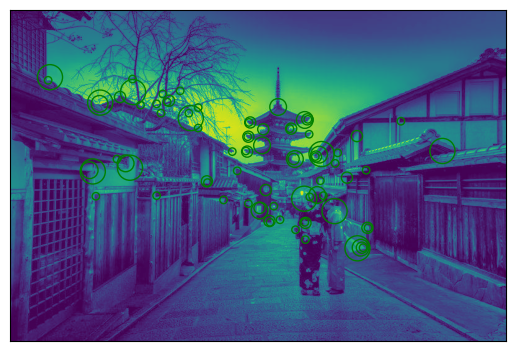

In [16]:
j = MultiScaleCornerDetect(kyoto, sigma, r, k, theta_corn, s, N )

interest_points_visualization(kyoto, j)

2.3. Ανίχνευση Blobs

In [10]:
def BlobDetect(I, sigma, r, k, theta_corn):

    I = np.float32(I)

    # Filter
    Is = Gaussian(I,sigma)

    # First Derivative
    Ix, Iy = np.gradient(Is)

    # Second Derivative
    Lxx = np.gradient(Ix, axis=0)
    Lyy = np.gradient(Iy, axis=1)
    Lxy = np.gradient(Ix, axis=1)

    # Compute Determinant
    R = Lxx * Lyy - Lxy ** 2

    # Find local maxima
    ns = np.ceil(3 * sigma) * 2 + 1
    B_sq = disk_strel(ns)
    Cond1 = (R == cv2.dilate(R, B_sq))

    # Threshold it
    maxR = np.max(R)
    Cond2 = (R > theta_corn * maxR)

    blobs = np.zeros_like(I)

    
    blobs[Cond1 & Cond2] = 1
    final_points = []
    x_indices, y_indices = np.nonzero(blobs)
    final_points = np.column_stack((y_indices,x_indices, np.full_like(y_indices, sigma)))

    return(final_points)

<AxesSubplot:>

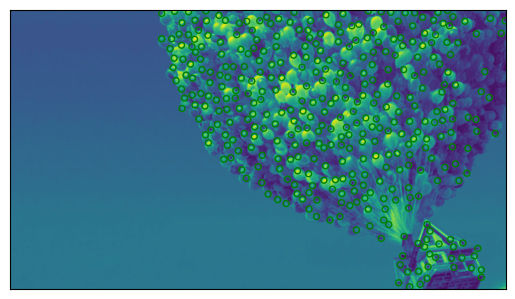

In [11]:
a= BlobDetect(up, sigma, r, k, theta_corn)
 
interest_points_visualization(up, a)

In [12]:
def MultiScaleBlobDetect(I, sigma, r, k, theta_corn, s, N):
    sigma_arr = []
    rho_arr = []
    corners = []
    LoG = []
    final_blobs = []
    
    I = I.astype(float)/255

    for i in range(N):
        sigma_arr.append((s ** i) * sigma)
        rho_arr.append((s ** i) * r)

        corners.append(BlobDetect(I, sigma_arr[i], rho_arr[i], k, theta_corn))
        
        kernel = Gauss2Dfilter(sigma_arr[i])
        kernel = sigma_arr[i]**2 * cv2.Laplacian(kernel, cv2.CV_64F)
        LoG.append(np.abs(cv2.filter2D(I, -1, kernel)))
        
    

    
    for i in range(N):
        for j in range(len(corners[i])):
            # corners[i] contains all the edge points for σi
            y, x, sigmai = corners[i][j]
            currentLog = LoG[i][x, y]                
            if i == 0:
                previousLog = 0
                nextLog = LoG[i+1][x, y]
            elif i == N-1:
                previousLog = LoG[i-1][x, y]
                nextLog = 0
            else: 
                previousLog = LoG[i-1][x, y]
                nextLog = LoG[i+1][x, y]
            if ((currentLog > previousLog) & (currentLog > nextLog)):
                final_blobs.append([y, x, sigma_arr[i]])
    
    final_blobs = np.array(final_blobs)  # convert list to numpy array
    
    return final_blobs

<AxesSubplot:>

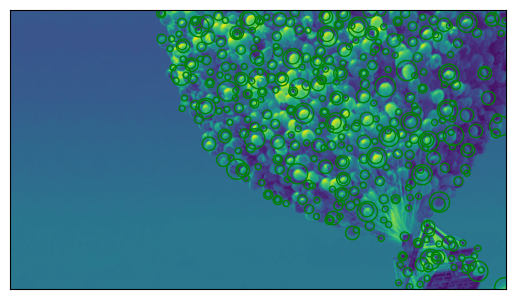

In [13]:
a= MultiScaleBlobDetect(up, sigma, r, k, theta_corn, s, N)
 
interest_points_visualization(up, a)

<h2>2.5  BOX FILTERS </h2>

In [14]:
height, width = up.shape

integral = np.zeros((height, width), dtype=np.uint32)


cumsum_rows = np.cumsum(up, axis=0)
cumsum_cols = np.cumsum(cumsum_rows, axis=1)


integral[1:, 1:] = cumsum_cols[:-1, :-1]


n= int(2*np.ceil(3*sigma)+1)

Dxx_height = 4*np.floor(n/6)+1
Dxx_width = 2*np.floor(n/6)+1

Dyy_height = 2*np.floor(n/6)+1
Dyy_width = 4*np.floor(n/6)+1

Dxy_height = 2*np.floor(n/6)+1
Dxy_width = 2*np.floor(n/6)+1

# Calculate corner response
Dxx = np.zeros((height, width))
Dyy = np.zeros((height, width))
Dxy = np.zeros((height, width))

# Calculate Dxx
Dxx[Dxx_height:, Dxx_width:] = integral[:-Dxx_height, :-Dxx_width] + integral[Dxx_height:, Dxx_width:] - \
                               integral[:-Dxx_height, Dxx_width:] - integral[Dxx_height:, :-Dxx_width]
Dxx[:Dxx_height, :] = Dxx[Dxx_height, :]
Dxx[:, :Dxx_width] = Dxx[:, Dxx_width]

# Calculate Dyy
Dyy[Dyy_height:, Dyy_width:] = integral[:-Dyy_height, :-Dyy_width] + integral[Dyy_height:, Dyy_width:] - \
                               integral[:-Dyy_height, Dyy_width:] - integral[Dyy_height:, :-Dyy_width]
Dyy[:Dyy_height, :] = Dyy[Dyy_height, :]
Dyy[:, :Dyy_width] = Dyy[:, Dyy_width]

# Calculate Dxy
Dxy[Dxy_height:, Dxy_width:] = integral[:-Dxy_height, :-Dxy_width] + integral[Dxy_height:, Dxy_width:] - \
                               integral[:-Dxy_height, Dxy_width:] - integral[Dxy_height:, :-Dxy_width]
Dxy[:Dxy_height, :] = Dxy[Dxy_height, :]
Dxy[:, :Dxy_width] = Dxy[:, Dxy_width]


print(Dxx)

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
print(Dxx_width)

5.0
